In [2]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# Funcion de limpieza general: Creamos una unica base completa en un excel, con mismas columnas y en el mismo orden.


def limpieza_general():
    ind2004 = pd.read_stata('usu_individual_t104.dta')
    ind2024 = pd.read_excel('usu_individual_T124.xlsx')
    ind2004.set_index('CODUSU', inplace=True)
    ind2024.set_index('CODUSU', inplace=True)
    ind2024 = ind2024.loc[:, ~ind2024.columns.str.contains("CH05")]
    ind2004.columns = ind2004.columns.str.upper()

    cols_2004 = set(ind2004.columns)
    cols_2024 = set(ind2024.columns)

    sobran_2004 = cols_2004 - cols_2024
    sobran_2024 = cols_2024 - cols_2004
    ind2004 = ind2004.drop(columns=sobran_2004)
    ind2024 = ind2024.drop(columns=sobran_2024)

    if ind2024.shape[1] == ind2004.shape[1]:
        print(
            f"Igual cantidad de columnas: {ind2004.shape[1]}")
    else:
        print(
            f'No son iguales: 2024: {ind2024.shape[1]}, 2004:{ind2004.shape[1]}')

    ind2024 = ind2024[ind2004.columns]

    base_completa = pd.concat([ind2004, ind2024], axis=0)
    variables_elegidas = ['ANO4', 'ESTADO', 'CH04', 'CH06', 'CH10', 'CH12', 'CH13', 'CH14', 'PP04A', 'PP04B_COD',
                          'PP07C', 'CAT_INAC', 'P21', 'PP3E_TOT', 'PP3F_TOT']
    base_completa = base_completa[variables_elegidas]
    base_completa.to_excel('BaseLimpiaEPH.xlsx', index=False)

    print("Archivo exportado a Excel.")


limpieza_general()

def limpieza_edad():
    ind2004 = pd.read_excel('BaseLimpiaEPH.xlsx')
    valores_unicos_2004 = ind2004['CH06'][~ind2004['CH06'].apply(
        lambda x: isinstance(x, (int, float)))].unique()
    print("Valores no numéricos únicos en CH06 (2004):")
    print(valores_unicos_2004)

    año2004 = ind2004['ANO4'] == 2004
    no_numeros = ind2004.loc[año2004, 'CH06'][~ind2004.loc[año2004, 'CH06']
                                              .apply(lambda x: isinstance(x, (int, float)))].unique()
    print("Valores no numéricos únicos en CH06 (2004):", no_numeros)

    reemplazos = {'Menos de 1 año': 1, '98 y más años': 99}
    series_2004 = ind2004.loc[año2004, 'CH06'].astype(str).replace(reemplazos)
    ind2004.loc[año2004, 'CH06'] = pd.to_numeric(series_2004, errors='coerce')

    print('Valores de edad corregidos solo para 2004.')
    ind2004.to_excel('BaseLimpiaEPH.xlsx', index=False)
    print('Archivo guardado')


limpieza_edad()

# Limpiamos la variable "Estado" para que solo tenga valores numéricos en cuanto a la ocupación, desocupación y otros resultados.


def limpieza_estado():
    Est = pd.read_excel('BaseLimpiaEPH.xlsx')

    valores_unicos_2004 = Est['ESTADO'][~Est['ESTADO'].apply(
        lambda x: isinstance(x, (int, float)))].unique()
    print(
        f"Valores no numéricos únicos en ESTADO (2004):{valores_unicos_2004}")

    Est['ESTADO'] = Est['ESTADO'].astype(str)
    Est['ESTADO'] = Est['ESTADO'].replace({
        'Ocupado': 1,
        'Desocupado': 2,
        'Inactivo': 3,
        'Menor de 10 años': 4,
        'Entrevista individual no realizada (no respuesta al cuestion': 0})
    Est['ESTADO'] = pd.to_numeric(Est['ESTADO'], errors='coerce')

    print(f'Valores en ESTADO 2004:{Est['ESTADO'].unique()}')
    print(f'Tipo de valores: {Est['ESTADO'].dtype}')

    Est.to_excel('BaseLimpiaEPH.xlsx', index=False)
    print('Limpieza guardada.')

limpieza_estado()

# Luego de la limpieza, realizamos lo pedido:
# Creamos la variable "edad2", que es todas las edades elevadas al cuadrado, y añadimos la columna a la base.


def edad2():
    var_nueva = pd.read_excel('BaseLimpiaEPH.xlsx')
    var_nueva['edad2'] = np.square(var_nueva['CH06'])
    var_nueva.to_excel('BaseLimpiaEPH.xlsx')
    print('Nueva variable edad2 añadida.')


edad2()

# Limpiamos base en las variables "CH10", "CH12", "CH13" y "CH14" para crear la variable "educ" (Cant. de años de educación.)


def educ_limpieza():
    df = pd.read_excel('BaseLimpiaEPH.xlsx')
    df['CH10'] = df['CH10'].astype(str)
    df['CH10'] = df['CH10'].replace({
        'No asiste, pero asistió': 2,
        'Sí, asiste': 1,
        'Nunca asistió': 3,
        'Ns./Nr.': 9})
    df['CH10'] = pd.to_numeric(df['CH10'], errors='coerce')

    df['CH12'] = df['CH12'].astype(str).dropna()
    df['CH12'] = df['CH12'].replace({
        'Secundario': 4,
        'Primario': 2,
        'Universitario': 7,
        'Terciario': 6,
        'Jardín/Preescolar': 1,
        'Polimodal': 5,
        'EGB': 3,
        'Educación especial (discapacitado)': 9,
        'Ns./Nr.': 9,
        '99': 9})
    df['CH12'] = pd.to_numeric(df['CH12'], errors='coerce')

    df['CH13'] = df['CH13'].astype(str)
    df['CH13'] = df['CH13'].replace({
        'No': 2,
        'Sí': 1,
        'Ns./Nr.': 9})
    df['CH13'] = pd.to_numeric(df['CH13'], errors='coerce')

    df['CH14'] = df['CH14'].replace({i: f'0{i}' for i in range(0, 10)})
    df['CH14'] = pd.to_numeric(df['CH14'], errors='coerce')

    # Chequeamos los valores unicos de cada variable luego de limpiar.
    print(f'Valores en CH10:{df['CH10'].unique()}')
    print(f'Valores en CH12:{df['CH12'].unique()}')
    print(f'Valores en CH13:{df['CH13'].unique()}')
    print(f'Valores en CH14:{df['CH14'].unique()}')
    df.to_excel('BaseLimpiaEPH.xlsx', index=False)

    # Creamos una función que, en caso de que asista o hayaa asistido a alguna institución de educación, -
    # nos devuelva distintos valores en cada una. Si asiste o asistió a secundaria como última institución -
    # se hace 6 (Por primaria) + el último año cursado.

educ_limpieza()

def educ():
    df = pd.read_excel('BaseLimpiaEPH.xlsx')

    def educ(row):
        if row['CH10'] in [1]:  # Si asiste a alguna institución:
            if row['CH14'] in [99, 98]:
                # Educación especial.
                return 6
            else:
                # No contamos jardín como años de educación.
                if row['CH12'] == 1:
                    return 0
                # Primaria, al consultar por ultimo año cursado, esa es su cantidad de años.
                elif row['CH12'] == 2:
                    return row['CH14']
                # EGB, cant. de años maximo es 9, dirá los años cursados en su respuesta de 'CH14'
                elif row['CH12'] == 3:
                    return row['CH14']
                # Secundaria, 6 de primaria + ultimo año cursado.
                elif row['CH12'] == 4:
                    return 6 + row['CH14']
                # Polimodal, 8 años de EGB + ultimo año cursado.
                elif row['CH12'] == 5:
                    return 9 + row['CH14']
                # Terciario, 12 años de primaria y secundaria + ultimo año cursado.
                elif row['CH12'] == 6:
                    return 12 + row['CH14']
                elif row['CH12'] == 7:  # Univ, lo mismo que terciario.
                    return 12 + row['CH14']
                # Posgrado, asumo 5 años de educación universitaria: 17 + ultimo año cursado
                elif row['CH12'] == 8:
                    return 17 + row['CH14']
                elif row['CH12'] == 9:  # Ed. especial, asumo 6.
                    return row['CH14']
                else:
                    return 0
        elif row['CH10'] in [2]:
            if row['CH13'] in [1]:
                if row['CH14'] in [99, 98]:
                    # Educación especial.
                    return 6
                else:
                    # No contamos jardín como años de educación.
                    if row['CH12'] == 1:
                        return 0
                    # Primaria
                    elif row['CH12'] == 2:
                        return 6
                    # EGB, cant. de años maximo es 9
                    elif row['CH12'] == 3:
                        return 9
                    # Secundaria, 6 de primaria + 6
                    elif row['CH12'] == 4:
                        return 12
                    # Polimodal, 8 años de EGB + 3
                    elif row['CH12'] == 5:
                        return 12
                    # Terciario, 12 años de primaria y secundaria + ultimo año cursado.
                    elif row['CH12'] == 6:
                        return 15
                    elif row['CH12'] == 7:  # Univ, lo mismo que terciario.
                        return 17
                    # Posgrado, asumo 5 años de educación universitaria: 17 + 1 de posgrado.
                    elif row['CH12'] == 8:
                        return 18
                    elif row['CH12'] == 9:  # Ed. especial.
                        return 6
                    else:
                        return 0
            elif row['CH13'] in [2]:
                if row['CH14'] in [99, 98]:
                    # Educación especial.
                    return 6
                else:
                    # No contamos jardín como años de educación.
                    if row['CH12'] == 1:
                        return 0
                    # Primaria, al consultar por ultimo año cursado, esa es su cantidad de años.
                    elif row['CH12'] == 2:
                        return row['CH14']
                    # EGB, cant. de años maximo es 9, dirá los años cursados en su respuesta de 'CH14'
                    elif row['CH12'] == 3:
                        return row['CH14']
                    # Secundaria, 6 de primaria + ultimo año cursado.
                    elif row['CH12'] == 4:
                        return 6 + row['CH14']
                    # Polimodal, 9 años de EGB + ultimo año cursado.
                    elif row['CH12'] == 5:
                        return 9 + row['CH14']
                    # Terciario, 12 años de primaria y secundaria + ultimo año cursado.
                    elif row['CH12'] == 6:
                        return 12 + row['CH14']
                    elif row['CH12'] == 7:  # Univ, lo mismo que terciario.
                        return 12 + row['CH14']
                    # Posgrado, asumo 5 años de educación universitaria: 17 + ultimo año cursado
                    elif row['CH12'] == 8:
                        return 17 + row['CH14']
                    elif row['CH12'] == 9:  # Ed. especial.
                        return row['CH14']
                    else:
                        return 0
        elif row['CH10'] in [3]:  # Si nunca asistió, 0 años de educación.
            return 0
        else:
            return 0
    df['educ'] = df.apply(educ, axis=1)
    df.to_excel('BaseLimpiaEPH.xlsx', index=False)  # Guardamos la variable.
    print('Variable "educ" añadida.')

educ()

def salario_semanal():
    SMVM2004 = 350
    SMVM2024 = 202800
    pp = round(SMVM2024 / SMVM2004, 2)
    print(f'El SMVM de 2024T1 es {pp} veces el SMVM de 2004T1')

    df = pd.read_excel('BaseLimpiaEPH.xlsx')
    df.loc[(df['ANO4'] == 2004) & (df['P21'] > 0), 'salario_semanal'] = (
        df.loc[(df['ANO4'] == 2004) & (df['P21'] > 0), 'P21'] * pp / 21.65) * 5
    df.loc[(df['ANO4'] == 2024) & (df['P21'] > 0), 'salario_semanal'] = ((
        df.loc[(df['ANO4'] == 2024) & (df['P21'] > 0), 'P21']) / 21.65) * 5
    df.to_excel('BaseLimpiaEPH.xlsx', index=False)
    print('Ajuste hecho')
    prom_2004 = np.mean((df.loc[(df['ANO4'] == 2004) & (
        df['salario_semanal'] != 0), 'salario_semanal']) * 4.33)
    prom_2024 = np.mean(df.loc[(df['ANO4'] == 2024) & (df['P21'] != 0), 'P21'])

    # Chequeamos los promedios para verificar que las cantidades no sean absurdas tras el ajuste.
    print(f"Promedio 2004 ajustado: {round(prom_2004, 2)}")
    print(f"Promedio 2024: {round(prom_2024, 2)}")
salario_semanal()

df = pd.read_excel('BaseLimpiaEPH.xlsx')

# Reemplazamos valores inválidos con NaN si existen
df[['PP3E_TOT', 'PP3F_TOT']] = df[['PP3E_TOT', 'PP3F_TOT']].replace([99, 999, 9999], np.nan)

# Creamos la variable 'horastrab'
df['horastrab'] = df['PP3E_TOT'] + df['PP3F_TOT']

# Guardamos nuevamente en el Excel
df.to_excel('BaseLimpiaEPH.xlsx', index=False)
print('Variable "horastrab" añadida')

Igual cantidad de columnas: 171
Archivo exportado a Excel.
Valores no numéricos únicos en CH06 (2004):
['Menos de 1 año' '98 y más años']
Valores no numéricos únicos en CH06 (2004): ['Menos de 1 año' '98 y más años']
Valores de edad corregidos solo para 2004.
Archivo guardado
Valores no numéricos únicos en ESTADO (2004):['Inactivo' 'Ocupado' 'Desocupado' 'Menor de 10 años'
 'Entrevista individual no realizada (no respuesta al cuestion']
Valores en ESTADO 2004:[3 1 2 4 0]
Tipo de valores: int64
Limpieza guardada.
Nueva variable edad2 añadida.
Valores en CH10:[2 1 3 0 9]
Valores en CH12:[ 4.  2.  7.  6.  0.  1.  5.  3.  9. nan  8.]
Valores en CH13:[2 1 0 9]
Valores en CH14:[ 3. nan  4.  2.  1.  6.  0.  5.  7.  9. 99.  8. 98.]
Variable "educ" añadida.
El SMVM de 2024T1 es 579.43 veces el SMVM de 2004T1
Ajuste hecho
Promedio 2004 ajustado: 330230.47
Promedio 2024: 253270.44
Variable "horastrab" añadida


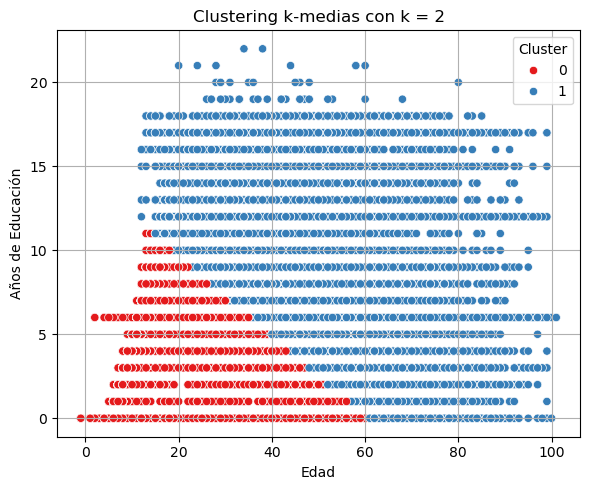

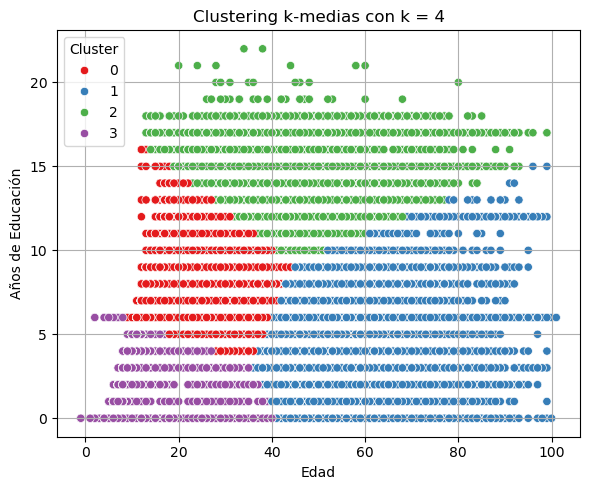

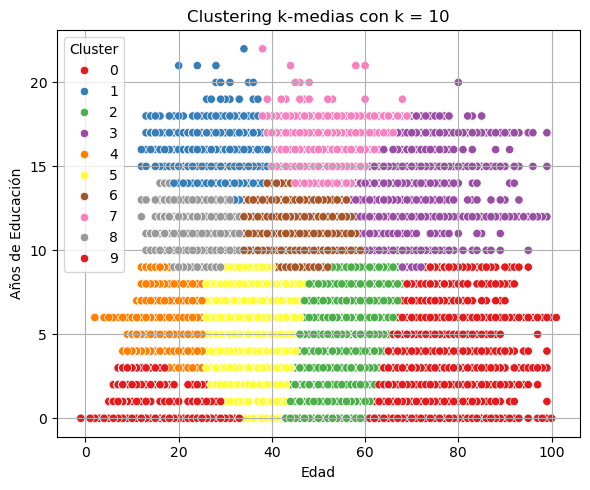

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Cargar la base
df = pd.read_excel('BaseLimpiaEPH.xlsx')

# Seleccionar solo las columnas necesarias (edad y educación)
df_cluster = df[['CH06', 'educ']].dropna()

# Normalizar los datos para mejorar el rendimiento de k-means
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Función para aplicar k-means y graficar
def graficar_kmeans(k, datos, original_data):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    clusters = kmeans.fit_predict(datos)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=original_data['CH06'],
        y=original_data['educ'],
        hue=clusters,
        palette='Set1',
        legend='full'
    )
    plt.title(f'Clustering k-medias con k = {k}')
    plt.xlabel('Edad')
    plt.ylabel('Años de Educación')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'cluster_k{k}.png', dpi=300)
    plt.show()

# Ejecutar para k = 2, 4 y 10
for k in [2, 4, 10]:
    graficar_kmeans(k, df_scaled, df_cluster)


El algoritmo de k-means con k=2 nos muestra el cluster 0 que agrupa a personas con poca o ninguna educación (hasta 10 años de educación formal) y de menor edad (concentración fuerte hasta los 35 años). Se puede ver que este primer grupo está compuesto por niños, adolescentes y jóvenes en proceso educativo y adultos con baja escolaridad. El cluster 1 contiene a la mayoría de las personas, con un rango más amplio, tanto de edad como de educación. Acá se puede ver que hay muchas personas adultas con distintas trayectorias educativas. Al estar unificados los datos 2004-2024, se puede interpretar que debido al contexto social y económico del año 2004 la gran mayoría de las personas adultas contaban con nula o muy poca educación formal, por eso se puede ver una gran cantidad de observaciones en esa conjunción. Con el correr de los años, las posibilidades de los individuos fueron incrementando, y para el año 2024, eran más las personas adultas con trayectorias educativas más largas. La segmentación es bastante general.

El algoritmo de k-means con k=4 nos segmenta al cluster 0 con un rango de edad que va desde los 15 hasta los 40 años aprox. con una educación de entre 6 y 13 años. Puede representar a jóvenes y adultos jóvenes con educación media en curso o completa, pero sin estudios superiores. El cluster 1 abarca un rango de edad de mayores de 30 a mayores de 90, con una educación muy variable pero con concentración en educación primaria o secundaria incompleta. Esto puede corresponder a adultos mayores con menor acceso educativo, típico de generaciones anteriores. El cluster 2 concentra a personas de entre 20 a 60 años con una educación formal de más de 13 años, y representa a individuos con una educación superior/universitaria completa y algunos con posgrado (>17), probablemente profesionales activos o académicos. Por último, la concentración del cluster 3 muestra personas de 0 a 25 años aprox. con 0 a 6 años de educación formal, es decir, este grupo está formado por niños iniciando o completando sus estudios, y adolescentes y jóvenes con estudios primarios únicamente.

Con k=10, podemos armar subgrupos por tramo educativo y edad interpretando el gráfico de la siguiente manera: con los cluster 2 y 5 podemos ver a los grupos con baja educación, es decir, con primaria incompleta o completa (0 a 6 años de educación formal). Con rango de edad de 0 a 30 años, el cluster 2 representa a la niñez y juventud con muy baja escolaridad y el cluster 5 a personas que completaron el nivel primario pero no accedieron al secundario, probablemente adultos con inserción laboral temprana y trayectorias educativas truncas. Como segundo subgrupo, tenemos los cluster 4, 6 y 9 que agrupan a personas con secundaria en curso/incompleta y completa; abarca desde jóvenes (~20 años) hasta adultos mayores (60 años) lo que indica distintas generaciones con el mismo nivel educativo. Un tercer subgrupo agrupa a las personas con educación superior: el cluster concentra jóvenes cursando su educación superior, el cluster 7 a jóvenes adultos que culminaron sus estudios terciarios/universitarios y el cluster 0 a adultos mayores de 40, probablemente con su profesión consolidada. El cluster 6 muestra a personas mayores de entre ~45 y ~75 que no culminaron sus estudios secundarios. Por último, tenemos a los cluster 8 y 1 que representa a adultos que no culminaron su educación primaria o secundaria. El cluster 8 agrupa personas de entre 35 y 60 años que no terminaron el nivel primario, y el cluster 1 a personas mayores de 60 que tampoco terminaron su primario aunque hay algunos que sí tienen cursados unos años del nivel secundario. 

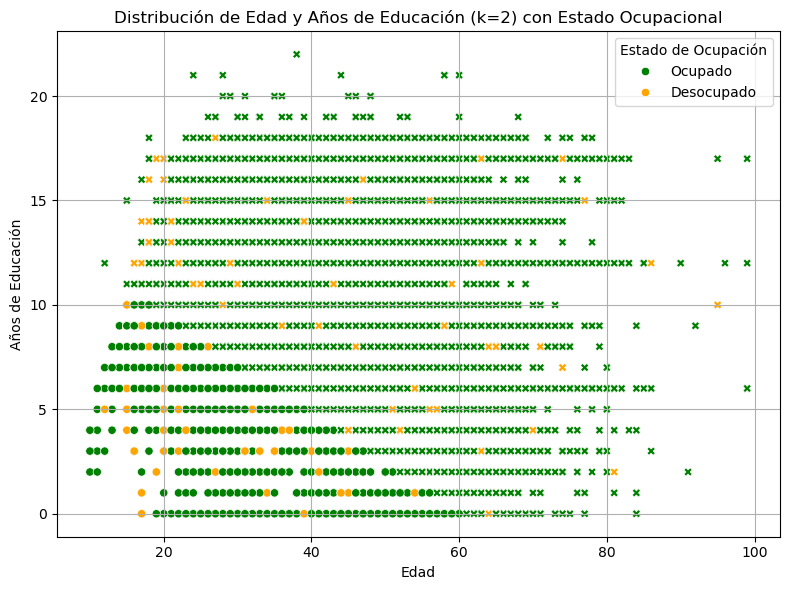

In [4]:
df_cluster_k2 = df[['CH06', 'educ', 'ESTADO']].dropna()

# Normaliza datos
scaler = StandardScaler()
df_scaled_k2 = scaler.fit_transform(df_cluster_k2[['CH06', 'educ']])

# Ejecutar k-medias con k=2
kmeans_k2 = KMeans(n_clusters=2, n_init=20, random_state=42)
clusters_k2 = kmeans_k2.fit_predict(df_scaled_k2)

# Agregar cluster y estado al dataframe
df_cluster_k2['Cluster'] = clusters_k2

# Filtrar solo Ocupado (1) y Desocupado (2)
df_cluster_k2 = df_cluster_k2[df_cluster_k2['ESTADO'].isin([1, 2])]

# Diccionario de colores para el estado ocupacional
palette_estado = {
    1: 'green',    # Ocupado
    2: 'orange'   # Desocupado
}

# Diccionario para etiquetas de la leyenda
estado_labels = {
    1: 'Ocupado',
    2: 'Desocupado'
}

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    x='CH06',
    y='educ',
    hue='ESTADO',
    style='Cluster',
    markers=['o', 'X'],
    data=df_cluster_k2,
    palette=palette_estado
)

plt.title('Distribución de Edad y Años de Educación (k=2) con Estado Ocupacional')
plt.xlabel('Edad')
plt.ylabel('Años de Educación')

handles, labels = scatter.get_legend_handles_labels()
n_clusters = df_cluster_k2['Cluster'].nunique()
estado_handles = handles[1:n_clusters+1]
estado_labels_leg = [estado_labels[int(l)] for l in labels[1:n_clusters+1]]

plt.legend(handles=estado_handles, labels=estado_labels_leg, title='Estado de Ocupación')
plt.grid(True)
plt.tight_layout()
plt.savefig('grafico_k2_ocupacion.png', dpi=300)
plt.show()


Al correr el algoritmo con k=2, donde nos muestra la distribución de Edad y Años de Educación separando a las personas ocupadas de las desocupadas, tenemos como resultado un gráfico que nos muestra un primer cluster, representado por círculos, que agrupa mayoritariamente a personas más jóvenes y con menos educación, y un segundo cluster representado por cruces, que agrupa a personas mayores y personas con más educación. El color verde representa a los ocupados y podemos ver una alta concentración en ambos clusters, y el amarillo identifica a los desocupados, que si bien son más dispersos, podemos ver un poco más de concentración en el primer cluster, probablemente debido al bajo nivel educativo.

C:\Users\andre\AppData\Local\Temp\ipykernel_22416\2174377771.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\andre\AppData\Local\Temp\ipykernel_22416\2174377771.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('dendrograma.png', dpi=300)
C:\Users\andre\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


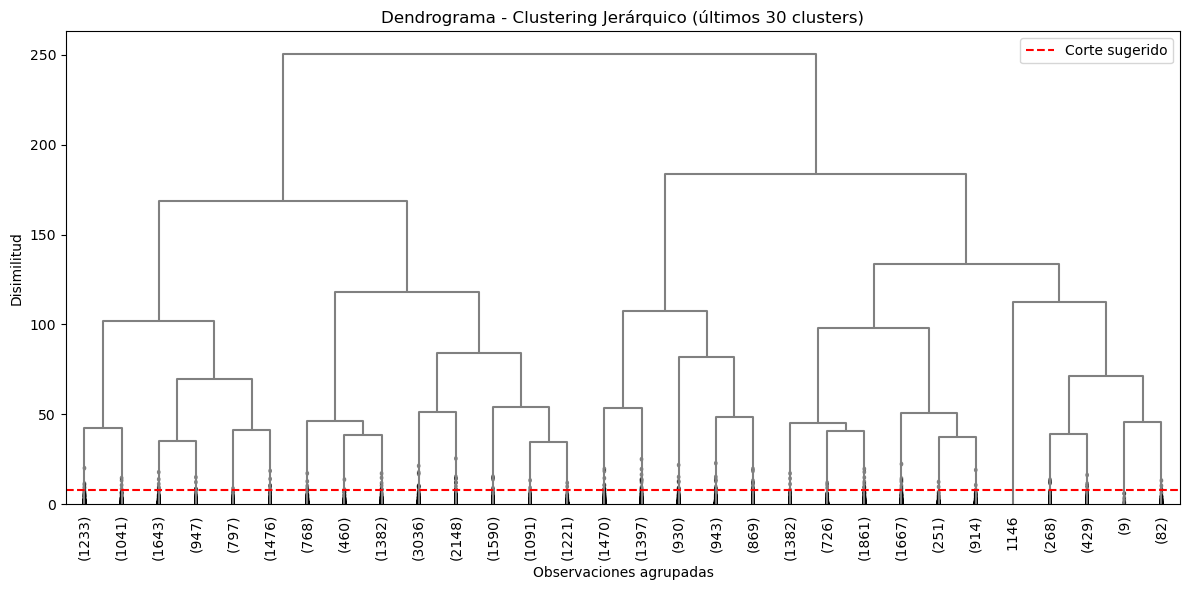

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

variables_cluster = df[['CH06', 'edad2', 'educ', 'salario_semanal', 'horastrab']].dropna()
scaler = StandardScaler()
variables_normalizadas = scaler.fit_transform(variables_cluster)

# Clustering jerárquico
linked = linkage(variables_normalizadas, method='ward') 

plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    truncate_mode='lastp',     # Muestra solo los últimos clusters grandes
    p=30,                      # Número de ramas a mostrar
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    color_threshold=8,         
    above_threshold_color='gray'
)
plt.axhline(y=8, c='red', linestyle='--', label='Corte sugerido')  # Línea de corte visual
plt.title('Dendrograma - Clustering Jerárquico (últimos 30 clusters)')
plt.xlabel('Observaciones agrupadas')
plt.ylabel('Disimilitud')
plt.legend()
plt.tight_layout()
plt.savefig('dendrograma.png', dpi=300)
plt.show()

Un dendrograma es un gráfico en forma de árbol que se utiliza en cluster jerárquico para mostrar cómo se agrupan las observaciones. En el eje horizontal están las observaciones, en este caso al ser muchas por utilizar las variables edad, edad2, educación, salario semanal y horas trabajadas, se muestran agrupadas según las características que compartan. En el eje vertical se muestra la distancia o disimilitud entre grupos de observaciones, es decir, cuán diferentes son entre sí. Las ramas van conectando las observaciones o grupos similares y se fusionan hasta que todos los datos están en un único grupo, que se muestra en la parte superior del gráfico. Cuanto más bajo se unan dos ramas, más parecidas son las observaciones. 